In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import gc

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import mplhep as hep
    hep.style.use(hep.style.ROOT)
    print("Using MPL HEP for ROOT style formating")
except:
    print("Instal MPL HEP for style formating")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
#from model import build_AE, build_VAE, Sampling
from model import Sampling


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-12GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instal MPL HEP for style formating


In [2]:
####configuration####
#global input_qcd, input_bsm, events, load_pickle, input_pickle, output_pfile, \
        #output_model_h5, output_model_json, output_history, output_result, \
        #model_type, batch_size, n_epochs

input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/BSM_preprocessed.h5"
events = 500000
load_pickle=False
input_pickle="data.pickle"
output_pfile="data.pickle"
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'
model_type='VAE'
batch_size= 1024
n_epochs = 150
result_auc = []

In [3]:
def main(hyperparameters):
    
    latent_dim = hyperparameters[:,0]
    outer_layer_width = hyperparameters[:,1]
    inner_layer_width = hyperparameters[:,2]
    
    def build_AE(input_shape,latent_dim, outer_layer_width, inner_layer_width):
        inputArray = Input(shape=(input_shape))
        x = BatchNormalization()(inputArray)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        # x = BatchNormalization()(x)
        # encoder = LeakyReLU(alpha=0.3)(x)
        #decoder
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

        #create autoencoder
        autoencoder = Model(inputs = inputArray, outputs=decoder)
        autoencoder.summary()
        # ae = AE(autoencoder)
        # ae.compile(optimizer=keras.optimizers.Adam(lr=0.00001))

        return autoencoder
    
    def build_VAE(input_shape, latent_dim, outer_layer_width, inner_layer_width):
    
        #encoder
        inputArray = Input(shape=(input_shape))
        x = BatchNormalization()(inputArray)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        mu = Dense(latent_dim, name = 'latent_mu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        logvar = Dense(latent_dim, name = 'latent_logvar', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Use reparameterization trick to ensure correct gradient
        z = Sampling()([mu, logvar])

        # Create encoder
        encoder = Model(inputArray, [mu, logvar, z], name='encoder')
        encoder.summary()

        #decoder
        d_input = Input(shape=(int(latent_dim),), name='decoder_input')
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(d_input)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        dec = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Create decoder 
        decoder = Model(d_input, dec, name='decoder')
        decoder.summary()
    
        # vae = VAE(encoder, decoder)
        # vae.compile(optimizer=keras.optimizers.Adam())

        return encoder,decoder
    
    if(load_pickle):
        if(input_pickle==''):
            print('Please provide input pickle files')
        with open(input_pickle, 'rb') as f:
            X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = pickle.load(f)
            bsm_labels=['VectorZPrimeToQQ__M50',
                  'VectorZPrimeToQQ__M100',
                  'VectorZPrimeToQQ__M200',
                  'VBF_HToInvisible_M125',
                  'VBF_HToInvisible_M125_private',
                  'ZprimeToZH_MZprime1000',
                  'ZprimeToZH_MZprime800',
                  'ZprimeToZH_MZprime600',
                  'GluGluToHHTo4B',
                  'HTo2LongLivedTo4mu_1000',
                  'HTo2LongLivedTo4mu_125_12',
                  'HTo2LongLivedTo4mu_125_25',
                  'HTo2LongLivedTo4mu_125_50',
                  'VBFHToTauTau',
                  'VBF_HH']
    else:
        if(input_qcd==''or input_bsm==''):
            print('Please provide input H5 files')
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, output_pfile,True)
        
    if(model_type=='AE'):
        autoencoder = build_AE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = AE(autoencoder)
        model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    elif(model_type=='VAE'):
        encoder, decoder = build_VAE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = VAE(encoder, decoder)
        model.compile(optimizer=keras.optimizers.Adam())

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    history = model.fit(X_train_flatten, X_train_scaled,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=callbacks)

    del X_train_flatten, X_train_scaled


    gc.collect()
    
    if(output_model_h5!=''):
        if(model_type=='VAE'):
            model.save(os.path.join(os.getcwd(),output_model_h5.split('.')[0]))
        else:
            model_json = autoencoder.to_json()
            with open(output_model_json, 'w') as json_file:
                json_file.write(model_json)
            autoencoder.save_weights(output_model_h5)


    if(output_history!=''):
        with open(output_history, 'wb') as f:
            pickle.dump(history.history, f)
    
    #load model
    model_dir = output_model_h5.split('.')[0]
    if(model_type=='AE'):
        with open(model_dir+"/model.json", 'r') as jsonfile: config = jsonfile.read()
        ae = tf.keras.models.model_from_json(config)    
        ae.load_weights(model_dir+"/model.h5")
        ae.summary()
        model = AE(ae)
    elif(model_type=='VAE'):
        encoder, decoder = VAE.load(model_dir, custom_objects={'Sampling': Sampling})
        encoder.summary()
        decoder.summary()
        model = VAE(encoder, decoder)
    
    from end2end import get_results
    data_file = input_pickle
    outdir = output_model_h5.split('.')[0]
    if not load_pickle: data_file = output_pfile
    results = get_results(input_qcd,input_bsm,data_file,outdir,events,model_type,latent_dim)   
    
    for key in results.keys():
        results[key]['loss'] = results[key]['loss'][np.isfinite(results[key]['loss'])]
        results[key]['total_loss'] = results[key]['total_loss'][np.isfinite(results[key]['total_loss'])]
        results[key]['radius'] = results[key]['radius'][np.isfinite(results[key]['radius'])]

    signal_eff={}

    for key in results.keys():
        if key=='QCD': continue
        signal_eff[key]={}
        true_label = np.concatenate(( np.ones(results[key]['loss'].shape[0]), np.zeros(results['QCD']['loss'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['MSE_loss']=tpr_loss[fpr_loss<0.000125][-1]

        auc_loss = auc(fpr_loss, tpr_loss)

    if(model_type=='VAE'):
        #plt.figure(figsize=(10,10))
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['total_loss'].shape[0]), np.zeros(results['QCD']['total_loss'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['total_loss'], results['QCD']['total_loss'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['KL_loss']=tpr_loss[fpr_loss<0.000125][-1]

            auc_loss = auc(fpr_loss, tpr_loss)
  
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['radius'].shape[0]), np.zeros(results['QCD']['radius'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['radius'], results['QCD']['radius'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['radius']=tpr_loss[fpr_loss<0.000125][-1]
        
        
            auc_loss = auc(fpr_loss, tpr_loss)
    
    signal_eff_pd = pd.DataFrame.from_dict(signal_eff).transpose()

    #print('The auc is, ', auc_loss)
    #print('The efficiency is, ', -(tpr_loss[fpr_loss<0.000125][-1]))
    result_auc.append(auc_loss)
    return -(tpr_loss[fpr_loss<0.000125][-1])
    #return auc_loss


In [7]:
%matplotlib inline  
import GPy
import GPyOpt
from numpy.random import seed

bounds = [{'name': 'latent_dim', 'type': 'discrete', 'domain':(4,6,8)},
          {'name': 'outer_layer_width', 'type': 'discrete', 'domain':(16, 32, 64)},
          {'name': 'inner_layer_width', 'type': 'discrete', 'domain':(16, 32, 64)}]

max_iter = 1000
myProblem = GPyOpt.methods.BayesianOptimization(main, domain=bounds)
myProblem.run_optimization(max_iter)


*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 57)]         0           []                               
         

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 57)          228         ['input_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_40 (Dense)               (None, 64)           3712        ['batch_normalization_40[0][0]'] 
                                                                                                  
 batch_normalization_41 (BatchN  (None, 64)          256         ['dense_40[0][0]']         

Epoch 1/150
196/196 [==============================] - 4s 12ms/step - loss: 1.0580 - reconstruction_loss: 0.4234 - kl_loss: 0.3266 - val_loss: 0.4303 - val_reconstruction_loss: 0.3157 - val_kl_loss: 0.1146 - lr: 0.0010
Epoch 2/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3886 - reconstruction_loss: 0.3029 - kl_loss: 0.0608 - val_loss: 0.3302 - val_reconstruction_loss: 0.2915 - val_kl_loss: 0.0388 - lr: 0.0010
Epoch 3/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3340 - reconstruction_loss: 0.2932 - kl_loss: 0.0276 - val_loss: 0.3088 - val_reconstruction_loss: 0.2870 - val_kl_loss: 0.0218 - lr: 0.0010
Epoch 4/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3080 - reconstruction_loss: 0.2907 - kl_loss: 0.0164 - val_loss: 0.2991 - val_reconstruction_loss: 0.2852 - val_kl_loss: 0.0139 - lr: 0.0010
Epoch 5/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3004 - reconstruction_loss: 0.2895 - kl_loss: 

Epoch 33/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2849 - reconstruction_loss: 0.2855 - kl_loss: 2.9582e-04 - val_loss: 0.2814 - val_reconstruction_loss: 0.2812 - val_kl_loss: 2.2308e-04 - lr: 1.0000e-05
Epoch 34/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2865 - reconstruction_loss: 0.2854 - kl_loss: 2.9998e-04 - val_loss: 0.2813 - val_reconstruction_loss: 0.2810 - val_kl_loss: 2.3690e-04 - lr: 1.0000e-05
Epoch 35/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2855 - reconstruction_loss: 0.2855 - kl_loss: 2.9668e-04 - val_loss: 0.2813 - val_reconstruction_loss: 0.2811 - val_kl_loss: 2.3920e-04 - lr: 1.0000e-05
Epoch 36/150
195/196 [============================>.] - ETA: 0s - loss: 0.2834 - reconstruction_loss: 0.2856 - kl_loss: 3.0108e-04
Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 [==============================] - 2s 11ms/step - loss: 0.2834 - reconstruction_loss

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 57)          228         ['input_10[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_45 (Dense)               (None, 16)           928         ['batch_normalization_45[0][0]'] 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 16)          64          ['dense_45[0][0]']         

Epoch 1/150
196/196 [==============================] - 3s 3ms/step - loss: inf - reconstruction_loss: 0.6037 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 57)          228         ['input_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_50 (Dense)         

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 57)]         0           []                  

196/196 [==============================] - 2s 11ms/step - loss: 0.2849 - reconstruction_loss: 0.2853 - kl_loss: 0.0014 - val_loss: 0.2839 - val_reconstruction_loss: 0.2824 - val_kl_loss: 0.0015 - lr: 0.0010
Epoch 14/150
195/196 [============================>.] - ETA: 0s - loss: 0.2867 - reconstruction_loss: 0.2850 - kl_loss: 0.0016
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
196/196 [==============================] - 2s 11ms/step - loss: 0.2867 - reconstruction_loss: 0.2849 - kl_loss: 0.0016 - val_loss: 0.2837 - val_reconstruction_loss: 0.2826 - val_kl_loss: 0.0012 - lr: 0.0010
Epoch 15/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2843 - reconstruction_loss: 0.2850 - kl_loss: 0.0012 - val_loss: 0.2833 - val_reconstruction_loss: 0.2822 - val_kl_loss: 0.0012 - lr: 1.0000e-04
Epoch 16/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2883 - reconstruction_loss: 0.2846 - kl_loss: 0.0014 - val_loss: 0.2833 - v

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_55 (BatchN  (None, 57)          228         ['input_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_55 (Dense)               (None, 64)           3712        ['batch_normalization_55[0][0]'] 
                                                                                                  
 batch_normalization_56 (BatchN  (None, 64)          256         ['dense_55[0][0]']         

Epoch 1/150
196/196 [==============================] - 2s 3ms/step - loss: inf - reconstruction_loss: 0.5992 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 57)          228         ['input_13[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_60 (Dense)         

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 57)]         0           []                  

196/196 [==============================] - 2s 11ms/step - loss: 0.2882 - reconstruction_loss: 0.2854 - kl_loss: 0.0042 - val_loss: 0.2864 - val_reconstruction_loss: 0.2824 - val_kl_loss: 0.0040 - lr: 0.0010
Epoch 14/150
196/196 [==============================] - 2s 12ms/step - loss: 0.2862 - reconstruction_loss: 0.2855 - kl_loss: 0.0037 - val_loss: 0.2864 - val_reconstruction_loss: 0.2825 - val_kl_loss: 0.0039 - lr: 0.0010
Epoch 15/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2888 - reconstruction_loss: 0.2854 - kl_loss: 0.0036 - val_loss: 0.2854 - val_reconstruction_loss: 0.2823 - val_kl_loss: 0.0031 - lr: 0.0010
Epoch 16/150
196/196 [==============================] - 2s 12ms/step - loss: 0.2864 - reconstruction_loss: 0.2853 - kl_loss: 0.0033 - val_loss: 0.2853 - val_reconstruction_loss: 0.2825 - val_kl_loss: 0.0028 - lr: 0.0010
Epoch 17/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2863 - reconstruction_loss: 0.2854 - kl_loss: 0.0027 -

Epoch 00045: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_65 (BatchN  (None, 57)          228         ['input_14[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_65 (Dense)               (None, 64)           3712        ['batch_normalization_65[0][0]'] 
                                                                                                  
 ba

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_70 (BatchN  (None, 57)          228         ['input_15[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_70 (Dense)               (None, 16)           928         ['batch_normalization_70[0][0]'] 
                                                                                                  
 batch_normalization_71 (BatchN  (None, 16)          64          ['dense_70[0][0]']         

Epoch 1/150
Batch 0: Invalid loss, terminating training
196/196 [==============================] - 2s 3ms/step - loss: inf - reconstruction_loss: 0.5491 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_75 (BatchN  (None, 57)          228         ['input_16[0][0]']               
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_80 (BatchN  (None, 57)          228         ['input_17[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_80 (Dense)               (None, 16)           928         ['batch_normalization_80[0][0]'] 
                                                                                                  
 batch_normalization_81 (BatchN  (None, 16)          64          ['dense_80[0][0]']         

Epoch 1/150
196/196 [==============================] - 2s 2ms/step - loss: inf - reconstruction_loss: 0.5625 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_85 (BatchN  (None, 57)          228         ['input_18[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_85 (Dense)         

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 57)          228         ['input_19[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_90 (Dense)               (None, 32)           1856        ['batch_normalization_90[0][0]'] 
                                                                                                  
 batch_normalization_91 (BatchN  (None, 32)          128         ['dense_90[0][0]']         

Epoch 1/150
196/196 [==============================] - 2s 3ms/step - loss: inf - reconstruction_loss: 0.5537 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_95 (BatchN  (None, 57)          228         ['input_20[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_95 (Dense)         

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_100 (Batch  (None, 57)          228         ['input_21[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_100 (Dense)              (None, 32)           1856        ['batch_normalization_100[0][0]']
                                                                                                  
 batch_normalization_101 (Batch  (None, 32)          128         ['dense_100[0][0]']        

Epoch 1/150
Batch 0: Invalid loss, terminating training
196/196 [==============================] - 3s 2ms/step - loss: inf - reconstruction_loss: 0.4908 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_105 (Batch  (None, 57)          228         ['input_22[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_110 (Batch  (None, 57)          228         ['input_23[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_110 (Dense)              (None, 64)           3712        ['batch_normalization_110[0][0]']
                                                                                                  
 batch_normalization_111 (Batch  (None, 64)          256         ['dense_110[0][0]']        

Epoch 1/150
196/196 [==============================] - 3s 3ms/step - loss: inf - reconstruction_loss: 0.6145 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_115 (Batch  (None, 57)          228         ['input_24[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_115 (Dense)        

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_120 (Batch  (None, 57)          228         ['input_25[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_120 (Dense)              (None, 32)           1856        ['batch_normalization_120[0][0]']
                                                                                                  
 batch_normalization_121 (Batch  (None, 32)          128         ['dense_120[0][0]']        

Epoch 1/150
Batch 0: Invalid loss, terminating training
196/196 [==============================] - 2s 2ms/step - loss: inf - reconstruction_loss: 0.5564 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_125 (Batch  (None, 57)          228         ['input_26[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_130 (Batch  (None, 57)          228         ['input_27[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_130 (Dense)              (None, 32)           1856        ['batch_normalization_130[0][0]']
                                                                                                  
 batch_normalization_131 (Batch  (None, 32)          128         ['dense_130[0][0]']        

Epoch 1/150
Batch 0: Invalid loss, terminating training
196/196 [==============================] - 2s 3ms/step - loss: inf - reconstruction_loss: 0.3516 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_135 (Batch  (None, 57)          228         ['input_28[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 57)]         0           []                  

196/196 [==============================] - 2s 11ms/step - loss: 0.2859 - reconstruction_loss: 0.2835 - kl_loss: 0.0031 - val_loss: 0.2844 - val_reconstruction_loss: 0.2816 - val_kl_loss: 0.0029 - lr: 0.0010
Epoch 14/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2865 - reconstruction_loss: 0.2834 - kl_loss: 0.0027 - val_loss: 0.2840 - val_reconstruction_loss: 0.2815 - val_kl_loss: 0.0025 - lr: 0.0010
Epoch 15/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2861 - reconstruction_loss: 0.2834 - kl_loss: 0.0024 - val_loss: 0.2835 - val_reconstruction_loss: 0.2813 - val_kl_loss: 0.0022 - lr: 0.0010
Epoch 16/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2843 - reconstruction_loss: 0.2832 - kl_loss: 0.0021 - val_loss: 0.2832 - val_reconstruction_loss: 0.2812 - val_kl_loss: 0.0020 - lr: 0.0010
Epoch 17/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2859 - reconstruction_loss: 0.2832 - kl_loss: 0.0019 -

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_140 (Batch  (None, 57)          228         ['input_29[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_140 (Dense)              (None, 16)           928         ['batch_normalization_140[0][0]']
                                                                                                  
 batch_normalization_141 (Batch  (None, 16)          64          ['dense_140[0][0]']        

Epoch 1/150
Batch 0: Invalid loss, terminating training
196/196 [==============================] - 3s 2ms/step - loss: inf - reconstruction_loss: 0.5567 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_145 (Batch  (None, 57)          228         ['input_30[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 57)]         0           []                  

196/196 [==============================] - 2s 11ms/step - loss: 0.2856 - reconstruction_loss: 0.2827 - kl_loss: 0.0012 - val_loss: 0.2824 - val_reconstruction_loss: 0.2816 - val_kl_loss: 8.0562e-04 - lr: 0.0010
Epoch 14/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2830 - reconstruction_loss: 0.2828 - kl_loss: 0.0011 - val_loss: 0.2822 - val_reconstruction_loss: 0.2814 - val_kl_loss: 8.2154e-04 - lr: 0.0010
Epoch 15/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2834 - reconstruction_loss: 0.2825 - kl_loss: 9.8009e-04 - val_loss: 0.2820 - val_reconstruction_loss: 0.2813 - val_kl_loss: 6.8582e-04 - lr: 0.0010
Epoch 16/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2827 - reconstruction_loss: 0.2826 - kl_loss: 8.8140e-04 - val_loss: 0.2822 - val_reconstruction_loss: 0.2814 - val_kl_loss: 7.7795e-04 - lr: 0.0010
Epoch 17/150
194/196 [============================>.] - ETA: 0s - loss: 0.2840 - reconstruction_loss: 0.2825 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_150 (Batch  (None, 57)          228         ['input_31[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_150 (Dense)              (None, 64)           3712        ['batch_normalization_150[0][0]']
                                                                                                  
 batch_normalization_151 (Batch  (None, 64)          256         ['dense_150[0][0]']        

Epoch 1/150
196/196 [==============================] - 4s 12ms/step - loss: 0.9680 - reconstruction_loss: 0.3431 - kl_loss: 0.2738 - val_loss: 0.3802 - val_reconstruction_loss: 0.2909 - val_kl_loss: 0.0894 - lr: 0.0010
Epoch 2/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3542 - reconstruction_loss: 0.2903 - kl_loss: 0.0525 - val_loss: 0.3206 - val_reconstruction_loss: 0.2864 - val_kl_loss: 0.0343 - lr: 0.0010
Epoch 3/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3175 - reconstruction_loss: 0.2881 - kl_loss: 0.0261 - val_loss: 0.3046 - val_reconstruction_loss: 0.2848 - val_kl_loss: 0.0199 - lr: 0.0010
Epoch 4/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3040 - reconstruction_loss: 0.2870 - kl_loss: 0.0161 - val_loss: 0.2974 - val_reconstruction_loss: 0.2842 - val_kl_loss: 0.0132 - lr: 0.0010
Epoch 5/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3005 - reconstruction_loss: 0.2863 - kl_loss: 

196/196 [==============================] - 2s 11ms/step - loss: 0.2842 - reconstruction_loss: 0.2838 - kl_loss: 7.8834e-04 - val_loss: 0.2819 - val_reconstruction_loss: 0.2812 - val_kl_loss: 7.3729e-04 - lr: 1.0000e-06
Epoch 35/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2827 - reconstruction_loss: 0.2838 - kl_loss: 7.8417e-04 - val_loss: 0.2819 - val_reconstruction_loss: 0.2813 - val_kl_loss: 7.2809e-04 - lr: 1.0000e-06
Epoch 36/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2839 - reconstruction_loss: 0.2838 - kl_loss: 7.8877e-04 - val_loss: 0.2819 - val_reconstruction_loss: 0.2813 - val_kl_loss: 7.3471e-04 - lr: 1.0000e-06
Epoch 37/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2851 - reconstruction_loss: 0.2838 - kl_loss: 7.8180e-04 - val_loss: 0.2820 - val_reconstruction_loss: 0.2813 - val_kl_loss: 7.4272e-04 - lr: 1.0000e-06
Epoch 00037: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/mo

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_160 (Batch  (None, 57)          228         ['input_33[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_160 (Dense)              (None, 16)           928         ['batch_normalization_160[0][0]']
                                                                                                  
 batch_normalization_161 (Batch  (None, 16)          64          ['dense_160[0][0]']        

Epoch 1/150
196/196 [==============================] - 4s 12ms/step - loss: 0.8516 - reconstruction_loss: 0.3978 - kl_loss: 0.1706 - val_loss: 0.3583 - val_reconstruction_loss: 0.3130 - val_kl_loss: 0.0453 - lr: 0.0010
Epoch 2/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3328 - reconstruction_loss: 0.2958 - kl_loss: 0.0295 - val_loss: 0.3160 - val_reconstruction_loss: 0.2947 - val_kl_loss: 0.0213 - lr: 0.0010
Epoch 3/150
196/196 [==============================] - 2s 11ms/step - loss: 0.3084 - reconstruction_loss: 0.2901 - kl_loss: 0.0168 - val_loss: 0.3045 - val_reconstruction_loss: 0.2910 - val_kl_loss: 0.0134 - lr: 0.0010
Epoch 4/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2996 - reconstruction_loss: 0.2880 - kl_loss: 0.0110 - val_loss: 0.2988 - val_reconstruction_loss: 0.2895 - val_kl_loss: 0.0093 - lr: 0.0010
Epoch 5/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2951 - reconstruction_loss: 0.2869 - kl_loss: 

194/196 [============================>.] - ETA: 0s - loss: 0.2832 - reconstruction_loss: 0.2835 - kl_loss: 6.1466e-04
Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 2s 11ms/step - loss: 0.2832 - reconstruction_loss: 0.2834 - kl_loss: 6.1564e-04 - val_loss: 0.2842 - val_reconstruction_loss: 0.2833 - val_kl_loss: 9.2016e-04 - lr: 1.0000e-06
Epoch 36/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2843 - reconstruction_loss: 0.2835 - kl_loss: 6.2964e-04 - val_loss: 0.2842 - val_reconstruction_loss: 0.2832 - val_kl_loss: 0.0011 - lr: 1.0000e-06
Epoch 37/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2829 - reconstruction_loss: 0.2836 - kl_loss: 6.1979e-04 - val_loss: 0.2841 - val_reconstruction_loss: 0.2831 - val_kl_loss: 9.8502e-04 - lr: 1.0000e-06
Epoch 38/150
196/196 [==============================] - 2s 11ms/step - loss: 0.2828 - reconstruction_loss: 0.2835 - kl_loss: 6.1063e-04 - v

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_165 (Batch  (None, 57)          228         ['input_34[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_165 (Dense)              (None, 16)           928         ['batch_normalization_165[0][0]']
                                                                                                  
 batch_normalization_166 (Batch  (None, 16)          64          ['dense_165[0][0]']        

Epoch 1/150
196/196 [==============================] - 3s 3ms/step - loss: inf - reconstruction_loss: 0.6600 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_170 (Batch  (None, 57)          228         ['input_35[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_170 (Dense)        

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 57)]         0           []                  

Total params: 8,953
Trainable params: 8,697
Non-trainable params: 256
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_175 (Batch  (None, 57)          228         ['input_36[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_175 (Dense)              (None, 64)           3712        ['batch_normalization_175[0][0]']
                                                       

Epoch 1/150
196/196 [==============================] - 3s 3ms/step - loss: inf - reconstruction_loss: 0.6449 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_180 (Batch  (None, 57)          228         ['input_37[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_180 (Dense)        

*** OutputFile Created


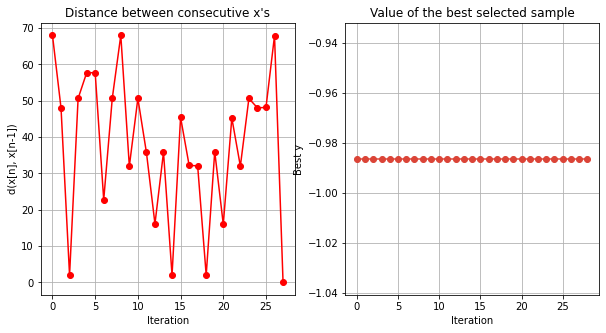

Writing evaluation results... 
    latent_dim  outer_layer_width  inner_layer_width  efficiency
0          8.0               64.0               64.0     0.98642
1          4.0               16.0               16.0     0.00008
2          6.0               64.0               16.0     0.77410
3          8.0               64.0               16.0     0.00008
4          6.0               16.0               32.0     0.94172
5          6.0               64.0               64.0     0.00010
6          8.0               16.0               32.0     0.53698
7          6.0               32.0               16.0     0.89792
8          8.0               16.0               64.0     0.65592
9          4.0               64.0               16.0     0.45354
10         4.0               32.0               16.0     0.66556
11         6.0               16.0               64.0     0.47484
12         6.0               32.0               32.0     0.52626
13         8.0               32.0               16.0     0.

In [9]:
# evaluate results of optimization
myProblem.plot_convergence()
print('Writing evaluation results... ')
param1 = myProblem.get_evaluations()[0][:,0].flatten()
param2 = myProblem.get_evaluations()[0][:,1].flatten()
param3 = myProblem.get_evaluations()[0][:,2].flatten()
out = -1*myProblem.get_evaluations()[1][:].flatten()
opt_results = {'latent_dim': param1,
               'outer_layer_width': param2,
               'inner_layer_width': param3,
               'efficiency': out}

evals = pd.DataFrame(opt_results)
print(evals)

print('The value of (latent_dim, outer_layer width, inner_layer_width) that maximizes efficiency is:'+str(myProblem.x_opt))
print('The the max efficiency found is: '+str(-1*myProblem.fx_opt))

In [14]:
print(result_auc)

[0.63943710064, 0.79221735708, 0.7945423632799998, 0.60699372368, 0.6891909890000001, 0.58573127104, 0.9335930666799999, 0.50742573496, 0.9929650016, 0.59408587704, 0.88573496032, 0.67252521572, 0.96800662576, 0.62302010072, 0.7683099225600001, 0.93026688004, 0.8305036036799999, 0.65289643344, 0.85312834476, 0.5990349908399999, 0.91303784776, 0.8540216689200001, 0.83105917364, 0.918152828, 0.8296060536800001, 0.95558725168, 0.7519221694, 0.9527656625600002, 0.5682080222, 0.53054660092, 0.65388695444, 0.58090283512, 0.8310504938800001, 0.6156742244800001, 0.8566961126, 0.9569680246400001, 0.7713848444]
